## Camera Calibration

In [42]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

images = glob.glob('./camera_cal/calibration*.jpg')

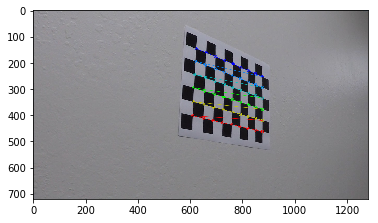

In [43]:
objpoints = []
imgpoints = []
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)


In [44]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

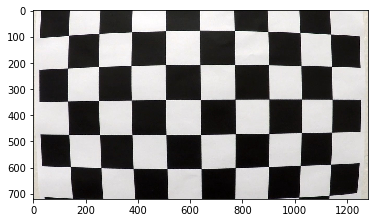

In [45]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None)
plt.imshow(img)

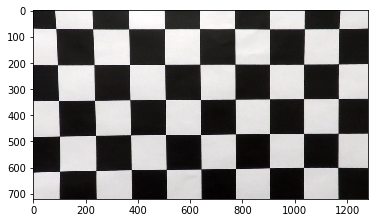

In [46]:
plt.imshow(undist)

## Functions used for generating binary images

In [47]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient =='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print('There is an error in the orient value')    
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    
    return binary_output
    

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely,abs_sobelx)
    
       
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    binary_output = np.uint8(binary_output)
    
    return binary_output

def hls_select(img,channel = 's', thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    if channel == 's':
        # 2) Apply a threshold to the S channel
        binary_output = np.zeros_like(S)
        binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    elif channel == 'h':
        binary_output = np.zeros_like(H)
        binary_output[(H > thresh[0]) & (H <= thresh[1])] = 1
    elif channel == 'l':
        binary_output = np.zeros_like(L)
        binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    else:
        print('There is an error in the channel value')
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output

## Functions used in the lane finding project

In [48]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size,sigma = 2):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# hough_lines modified to return also the lines it calculates as an array
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# function to avoid division by zero
def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

def average_lines(lines,imshape,filt_coeff=1,height_coeff=0.7):
    """
    This function gets the lines provided by hough transform as input. 
    The lines are into two groups, one group contains lines on the left side of car 
    and the other contains lines on the right side of the car. The group is filtered
    based on the mean and the average parameters of the lines are calculated. This is 
    used to draw the extrapolated lines on the image
        
    """
    lines = lines[:,0,:]    
    lines_left = []
    lines_right = []       
    
    for x1,y1,x2,y2 in lines:
        """
         safe_div function is to calculate slope returns zero slope in case of 
         line parallel to yaxis. Though it is wrong these lines are not interesting 
         and it will be ignored                  
        """
                
        slope = safe_div((y2-y1),(x2-x1)) 
        x_intercept = y1-slope*x1
        #x0 = float((y0-x_intercept)/slope)
        if slope < 0:  
            lines_left.append([slope,x_intercept])            
        elif slope > 0:
            lines_right.append([slope,x_intercept]) 
            
    left_lines = np.asarray(lines_left)
    right_lines = np.asarray(lines_right)       
    
    mean_left = np.mean(left_lines,axis=0)
    mean_right = np.mean(right_lines,axis=0)
    
    filt_left_lines = []
    filt_right_lines =  []
    
    for line in lines_left:
        diff = math.fabs((mean_left[0] - line[0])/mean_left[0])        
        if diff < filt_coeff:
            filt_left_lines.append(line)
    for line in lines_right:
        diff = math.fabs((mean_right[0]- line[0])/mean_right[0])
        if diff < filt_coeff:
            filt_right_lines.append(line)
            
    filt_left_lines = np.array(filt_left_lines)
    filt_right_lines = np.array(filt_right_lines)
    
    if len(filt_left_lines)>0:
        mean_left = np.mean(filt_left_lines,axis=0)
    if len(filt_right_lines)>0:
        mean_right = np.mean(filt_right_lines,axis=0)
    
    y1 = imshape[0]
    y2 = imshape[0]*height_coeff  
    
    x1_left = (y1-mean_left[1])/mean_left[0]
    x2_left = (y2-mean_left[1])/mean_left[0]
    
    x1_right = (y1-mean_right[1])/mean_right[0]
    x2_right = (y2-mean_right[1])/mean_right[0]
    
    mean_lines = np.array(([[[x1_left,y1,x2_left,y2]],[[x1_right,y1,x2_right,y2]]]),dtype=np.int32)
    mean_lines_img = np.zeros((imshape[0], imshape[1], 3), dtype=np.uint8)
    draw_lines(mean_lines_img, mean_lines,color=[255, 0, 0], thickness=7)
    
    return mean_lines_img

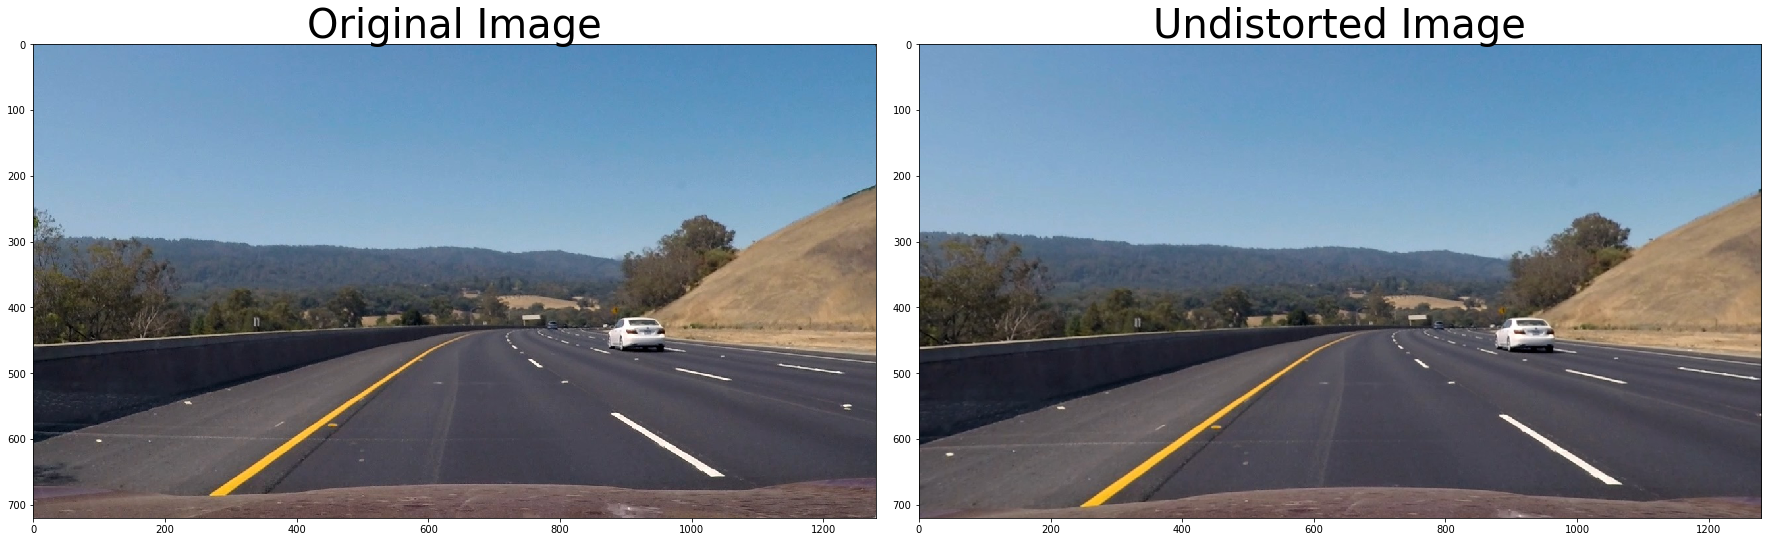

In [66]:
img = mpimg.imread('./test_images/test3.jpg')

undist = cv2.undistort(img, mtx, dist, None)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

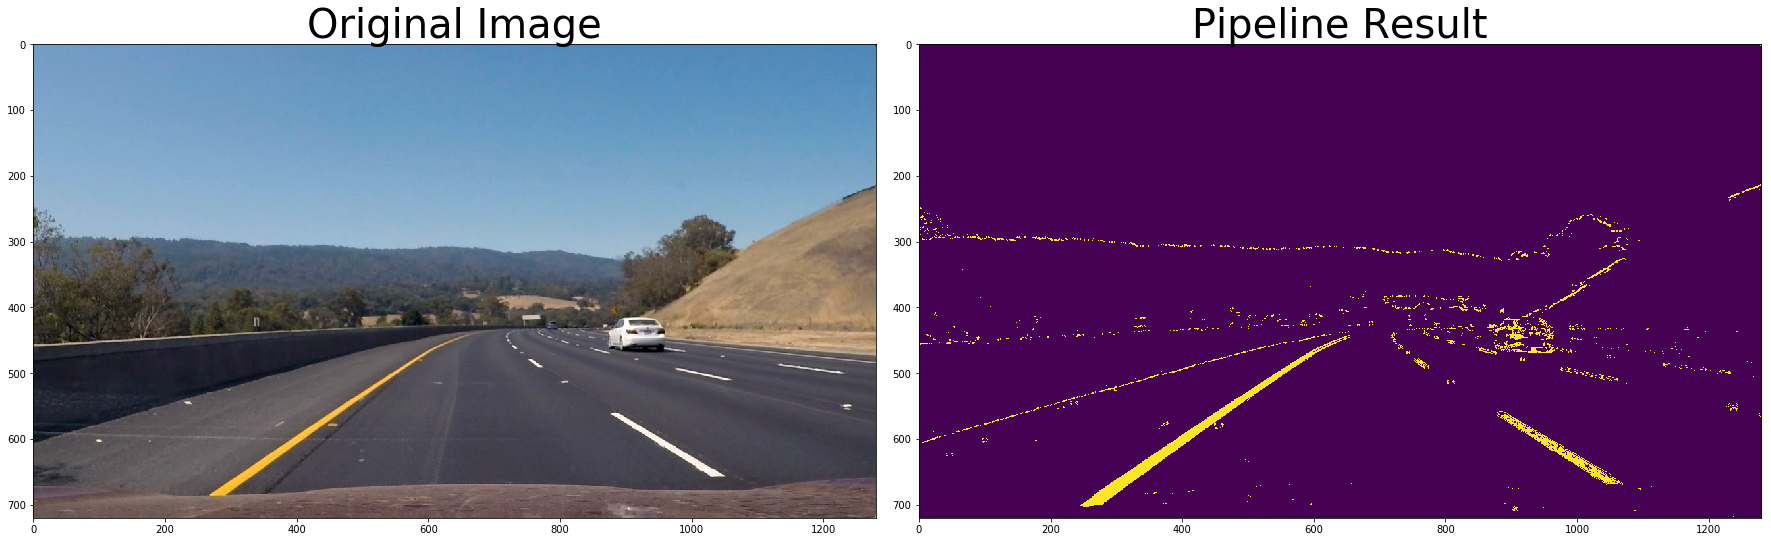

In [67]:
ksize = 5;
gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(50, 150))
grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(50, 150))
mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(50, 155))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(np.pi*30./180,np.pi*80./180))
s_binary = hls_select(undist,channel = 's', thresh=(150, 255))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) |((mag_binary == 1) & (dir_binary == 1))|( (s_binary ==1))] = 1
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(combined)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

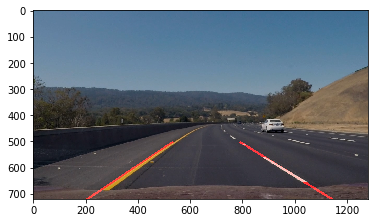

In [68]:
imshape = img.shape
width = imshape[1]
height = imshape[0]
combined = np.uint8(combined)*255
quad_parm = 0.13
vertices = np.array([[(0,height),(width*(0.5-quad_parm),height*(0.5+quad_parm)),(width*(0.5+quad_parm),height*(0.5+quad_parm)),(width,height)]], dtype=np.int32)
# masking the image from canny edge algorithm
masked_edges = region_of_interest(combined,vertices)

rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
[line_img,lines] = hough_lines(masked_edges,rho,theta,threshold,min_line_length,max_line_gap)


mean_line_img =  average_lines(lines,imshape)
lane_mark = weighted_img(mean_line_img,img,0.8,1,0)
plt.imshow(lane_mark)

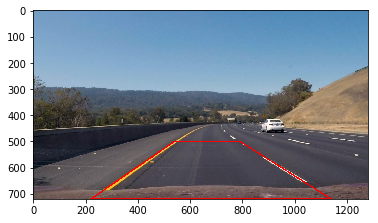

In [69]:
copy_image = np.copy(img)
poly_pts = np.array([[220,720],[540,500],[790,500],[1140,720]],dtype = np.int32)
copy_img = cv2.polylines(copy_image,[poly_pts],True,(255,0,0),lineType=8,thickness= 3)
plt.imshow(copy_img)

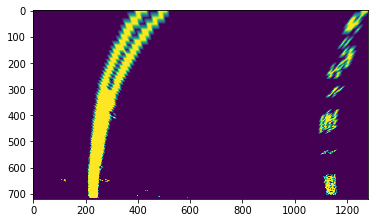

In [70]:
img_size = (img.shape[1],img.shape[0])
dst = np.array([[220,720],[220,500],[1140,500],[1140,720]],dtype = np.int32)
M = cv2.getPerspectiveTransform(np.float32(poly_pts),np.float32(dst))
Minv = cv2.getPerspectiveTransform(np.float32(dst),np.float32(poly_pts))
image_warped = cv2.warpPerspective(combined,M,img_size,flags=cv2.INTER_LINEAR)
plt.imshow(image_warped)

In [71]:
binary_warped = image_warped
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50



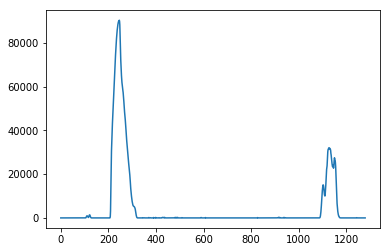

In [72]:
plt.plot(histogram)

In [73]:
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))



(720, 0)

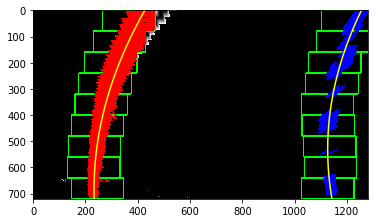

In [74]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [75]:
y_eval = np.max(ploty)
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


398.79490791 m 359.616880886 m


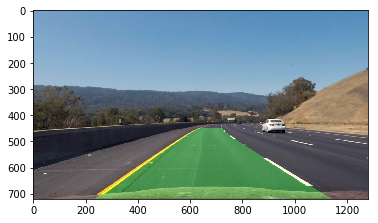

In [76]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(image_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)